In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc
from utils import log10eaxis, logjacob, makedist, makelogjacob, bkgdist, edisp, offsetaxis, fake_signal_position_dist, inverse_transform_sampling, psf, norme_vals_mesh, normoffset_vals_mesh, setup_full_fake_signal_dist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


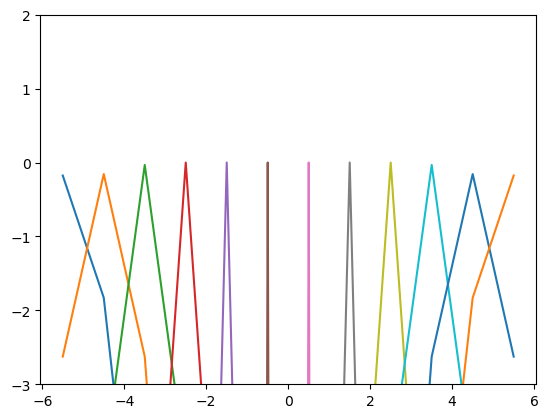

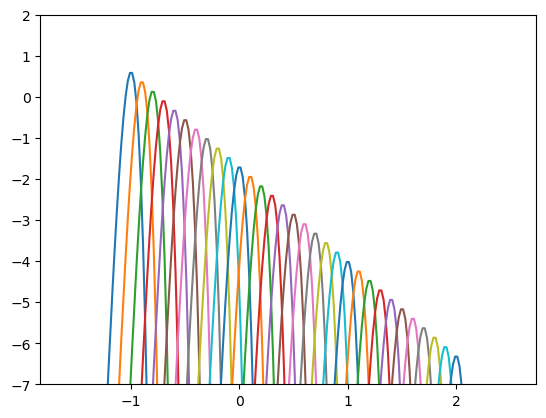

In [2]:
offsetvals = np.linspace(-5.5,5.5,12)
logevals = np.linspace(-1,2,31)

offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)

plt.figure()
for offsetval in offsetvals:
    plt.plot(offsetaxis, psf(offsetaxis, offsetval, 0.0))

plt.ylim([-3,2])
plt.show()


plt.figure()
for log10eval in logevals:
    plt.plot(log10eaxis, edisp(log10eaxis, log10eval, 0.0))
plt.ylim([-7,2])
plt.show()

In [3]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)
Nsamples=int(1e1)
truelogmassval = -1.0

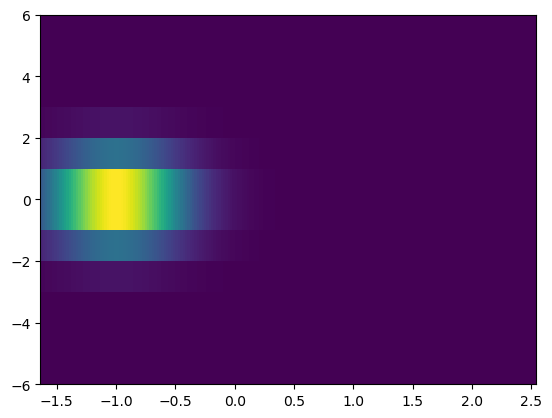

In [4]:
plt.figure()
plt.pcolormesh(log10eaxis, offsetaxis, np.exp(setup_full_fake_signal_dist(truelogmassval, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)))

In [5]:
sigbinnedprior = setup_full_fake_signal_dist(truelogmassval, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)+logjacob
flattened_sigbinnedprior = sigbinnedprior.flatten()

sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_sigbinnedprior, Nsamples=Nsamples),sigbinnedprior.shape)
siglogevals = log10eaxis[sigresultindices[1]]
sigoffsetvals = offsetaxis[sigresultindices[0]]

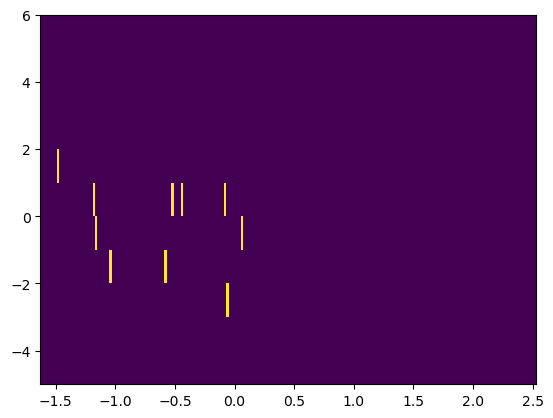

In [6]:
plt.figure()
plt.hist2d(siglogevals, sigoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
# for val in offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0]):
#     plt.axhline(val, alpha=0.1, c='tab:orange')
plt.show()

In [7]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]

100%|██████████| 10/10 [00:00<00:00, 1470.76it/s]


In [8]:
signal_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]


100%|██████████| 10/10 [00:00<00:00, 8665.92it/s]


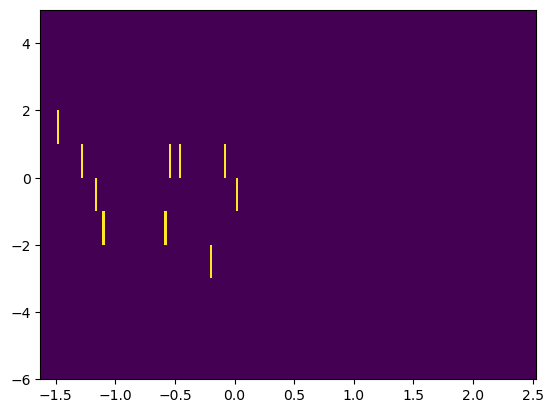

10.0

In [9]:
plt.figure()
histvals = plt.hist2d(signal_log10e_measured, signal_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.show()

np.sum(histvals[0])

In [10]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)

part1 = setup_full_fake_signal_dist(0.0, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)
part2=logjacob
part3=edisp(signal_log10e_measured[0], log10emesh, offsetmesh)
part4=psf(signal_offset_measured[0], offsetmesh, log10emesh)

In [11]:
special.logsumexp(part1+part2+part3+part4)

-13.171262617207404

In [12]:

def evaluateintegral(priorvals, logemeasured, offsetmeasured, log10emesh, offsetmesh):
    
    energyloglikelihoodvals=edisp(logemeasured, log10emesh, offsetmesh)
    pointspreadlikelihoodvals=psf(offsetmeasured, offsetmesh, log10emesh)
    integrand = priorvals+logjacob+energyloglikelihoodvals+pointspreadlikelihoodvals
    return special.logsumexp(integrand)


def evaluateformass(logmass, logemasuredvals, offsetmeasuredvals):
    log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)

    priorvals = setup_full_fake_signal_dist(logmass, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)
        
    product = np.sum([evaluateintegral(priorvals, logemeasured, offsetmeasured, log10emesh, offsetmesh) for logemeasured, offsetmeasured in zip(logemasuredvals, offsetmeasuredvals)])
    
    return product

In [13]:
massvals = np.linspace(truelogmassval-1/np.sqrt(Nsamples/10),truelogmassval+1/np.sqrt(Nsamples/10),61)
logposterior = [evaluateformass(logmass, signal_log10e_measured, signal_offset_measured) for logmass in notebook_tqdm(massvals)]

100%|██████████| 61/61 [00:11<00:00,  5.25it/s]


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_2063/625764978.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_2063/625764978.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ticks=np.arange(1,5))


1.0000000000000004


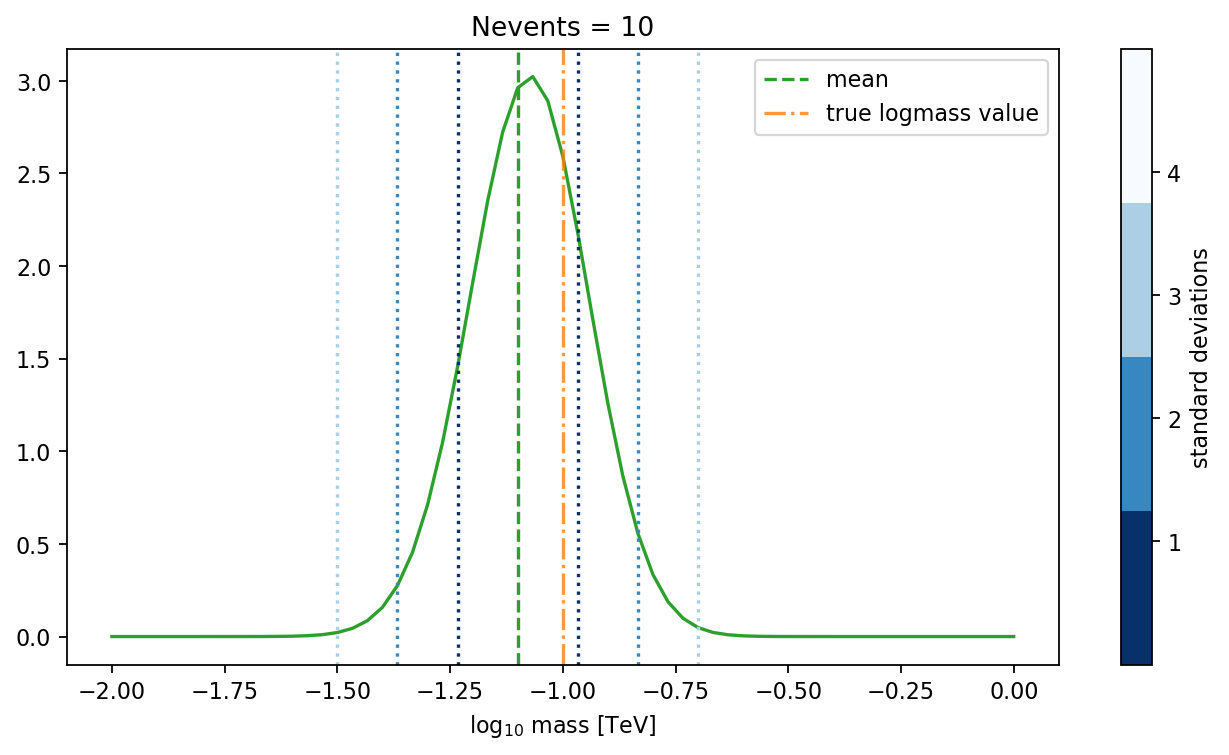

In [56]:
from scipy.stats import norm
from matplotlib import cm
import time

colormap = cm.get_cmap('Blues_r', 4)




deltalogmass = (massvals[1]-massvals[0])
normedposterior = np.exp(logposterior-special.logsumexp(logposterior+np.log(deltalogmass)))
cdfposterior = np.cumsum(normedposterior*deltalogmass)
print(cdfposterior[-1])
mean = massvals[np.abs(0.5-cdfposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
percentiles = []
for zscore in zscores:
    percentiles.append(massvals[np.abs(norm.cdf(zscore)-cdfposterior).argmin()])



plt.figure(dpi=160, figsize=(10,5))
plt.title(f'Nevents = {Nsamples}')
plt.plot(massvals, normedposterior, c='tab:green')
plt.axvline(mean, c='tab:green', ls='--', alpha=1, label='mean')
for o, percentile in enumerate(percentiles):
    color = colormap(np.abs(zscores[o])/4-0.01)

    plt.axvline(percentile, c=color, ls=':')
    

plt.axvline(truelogmassval, c='tab:orange', ls='-.', label='true logmass value', alpha=0.8)
plt.xlabel(r'log$_{10}$ mass [TeV]')
norm = mpl.colors.Normalize(vmin=0, vmax=5)

cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ticks=np.arange(1,5))
cb1.set_label(r'standard deviations')
plt.legend()
plt.savefig(time.strftime(f'Figures/TestFigures/logmassposterior_%m%d_%H%M_logmass={truelogmassval}.png'))
plt.show()

In [15]:
offsetvals = np.linspace(-5.5,5.5,12)
logevals = np.linspace(-1,2,31)

offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)




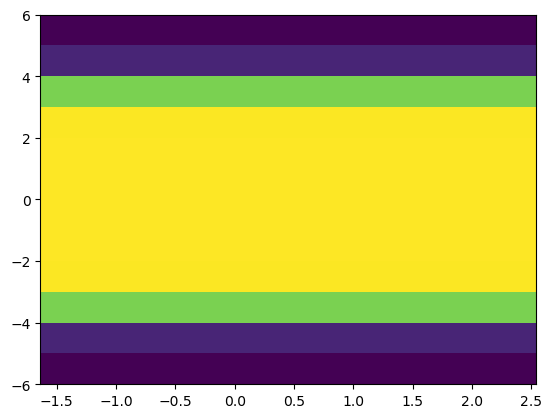

In [16]:
plt.figure()
plt.pcolormesh(log10eaxis, offsetaxis, np.exp(psf(0.0, offsetvalsmesh, logevalsmesh)).T)

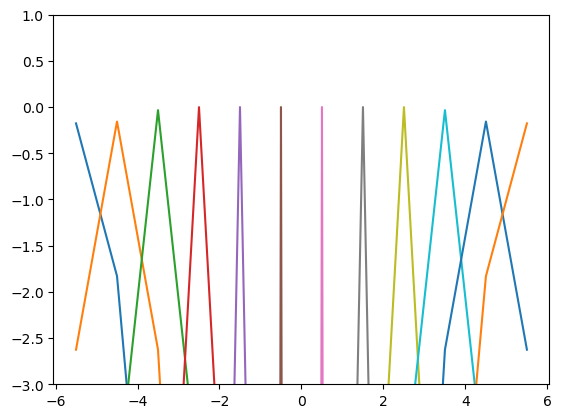

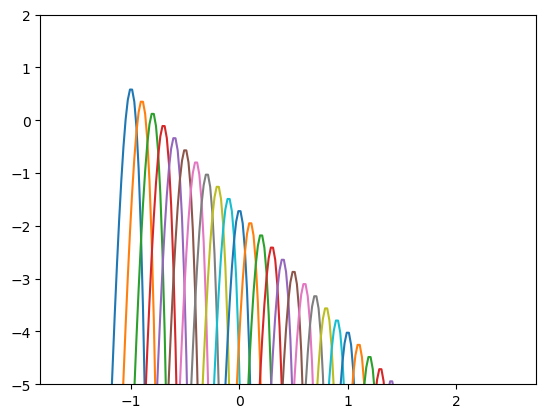

In [17]:
plt.figure()
for offsetval in offsetvals:
    plt.plot(offsetaxis, psf(offsetaxis, offsetval, 0.0))

plt.ylim([-3,1])
plt.show()


plt.figure()
for log10eval in logevals:
    plt.plot(log10eaxis, edisp(log10eaxis, log10eval, 0.0))
plt.ylim([-5,2])
plt.show()

In [18]:
testmatrix = np.zeros(shape=(3,2,5))
testarray  = np.arange(1,4)
testarray

array([1, 2, 3])

In [19]:
normalisation = np.sum((testmatrix.T+testarray).T, axis=0)
testmatrix-normalisation

array([[[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]],

       [[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]],

       [[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]]])

Message Ulrik